In [ ]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torchvision.transforms.functional import to_tensor
import os
from PIL import Image
from tqdm.notebook import trange
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
# import wandb
import random
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 64
EPOCHS = 200

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

In [ ]:
class BoardModel(nn.Module):
    def __init__(self):
        super(BoardModel, self).__init__()
        self.layers = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 64, 2),
            *[ResidualBlock(64, 64) for _ in range(1)],
            ConvBlock(64, 128, 2),
            *[ResidualBlock(128, 128) for _ in range(2)],
            ConvBlock(128, 256, 2),
            *[ResidualBlock(256, 256) for _ in range(3)],
            ConvBlock(256, 128, 2),
            *[ResidualBlock(128, 128) for _ in range(2)],
            ConvBlock(128, 64, 2),
            ConvBlock(64, 32, 2),
            ConvBlock(32, 1, 1, kernel_size=(4, 2), act='sigmoid'),
            nn.Flatten(),
        )

    def forward(self, x):
        return self.layers(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, stride=stride, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, padding=1, kernel_size=3, act=None):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, stride=stride, bias=False)
        self.act = act
        if self.act != 'sigmoid':
            self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        if self.act == 'sigmoid':
            out = torch.sigmoid(self.conv(x))
            return out
        out = F.relu(self.bn(self.conv(x)))
        return out

In [ ]:
from turtle import back


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dir, bgdir, transform=None):
        self.dir = dir
        self.bgdir = bgdir
        self.transform = transform
        self.background_images = os.listdir(bgdir)
        self.n = len(os.listdir(os.path.join(dir, 'pictures')))

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        img_path = os.path.join(self.dir, f"pictures/{idx}lbrn.png")
        img = Image.open(img_path)

        cords_path = os.path.join(self.dir, f"coords/{idx}coords.txt")
        with open(cords_path, 'r') as f:
            cords = f.read().replace('[', '').replace(']', '').split(',')
        x1, y1, x2, y2, x3, y3, x4, y4 = [float(x) / 168 for x in cords]
        y1, y2, y3, y4 = [1 - y for y in [y1, y2, y3, y4]]
        
        cords = np.array([x1, y1, x2, y2, x3, y3, x4, y4], dtype=np.float32)

        if self.transform and random.random() > 0.5:
            img, cords = self.transform(img, cords)
        img = np.array(img)

        rancho = random.random()

        if rancho < 0.25:
            background = np.array(np.random.randint(0, 225)).repeat(168 * 168 * 3).reshape(168, 168, 3)
            background = Image.fromarray(background.astype('uint8'))
        
        else:
            background = Image.open(os.path.join(self.bgdir, random.choice(self.background_images))).convert('RGB')
            bgCords = [random.randint(0, background.size[0] - 168), random.randint(0, background.size[1] - 168), ]
            background = background.crop((
                *bgCords,
                *[x + 168 for x in bgCords]
            ))

        background.paste(Image.fromarray(img), (0, 0), Image.fromarray(img))
        background = np.array(background)
            
        return to_tensor(background), torch.from_numpy(cords)
        
def mirror(img, coords):
    img_flipped, coords_flipped = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT), coords.reshape(4, 2)
    coords_flipped[:, 0] = 1 - coords_flipped[:, 0]
    coords_flipped = coords_flipped.reshape(-1)
    return img_flipped, coords_flipped

In [ ]:
model = BoardModel().to(DEVICE)
optimizer = AdamW(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_dataset = CustomDataset(
    dir='/home/robert/Documents/GitHub/OutSmarted/data/ConnectFour/labelren', 
    bgdir='/home/robert/Documents/GitHub/OutSmarted/data/ConnectFour/backgrounds',
    transform=mirror
)
print(train_dataset.n)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
def main():
    model.train()
    for epoch in trange(EPOCHS):
        for i, (img, cords) in enumerate(train_loader):
            img, cords = img.to(DEVICE), cords.to(DEVICE)
            outputs = model(img)
            loss = criterion(outputs, cords)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f"loss example: {loss.item()}")
        # wandb.log({"loss": loss.item()})

@torch.no_grad()
def show():
    model.eval()
    for i, (img, cords) in enumerate(train_loader):
        img, cords = img.to(DEVICE), cords.to(DEVICE)
        break
    outputs = model(img)
    img = img.cpu().numpy()
    cords = cords.cpu().numpy()
    outputs = outputs.cpu().numpy()
    for i in range(5):
        plot_image(img[i], cords[i], outputs[i])

def plot_image(image, cords, outputs):
    image = image.transpose(1, 2, 0)
    cords = cords * 168
    outputs = outputs * 168
    cords = cords.reshape(4, 2)
    outputs = outputs.reshape(4, 2)
    fig, ax = plt.subplots(1, 1)
    ax.imshow(image)
    print(outputs)
    ax.plot(cords[:, 0], cords[:, 1], 'ro')
    ax.plot(outputs[:, 0], outputs[:, 1], 'bo')
    plt.show()

In [ ]:
main()

In [ ]:
torch.save(model.state_dict(), 'model.pt')
torch.save(optimizer.state_dict(), 'optim.pth')

In [ ]:
show()

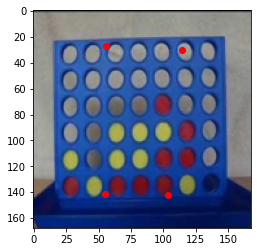

In [91]:
# test on real image
test_img = Image.open('hqdefault.jpg')
test_img = test_img.resize((168, 168))
test_img = test_img.convert('RGB')
imgT = to_tensor(test_img)
imgT = imgT.unsqueeze(0)
imgT = imgT.to(DEVICE)
outputs = model(imgT)
outputs = outputs.cpu().detach().numpy()
outputs = outputs.reshape(4, 2)
outputs = outputs * 168
plt.imshow(test_img)
plt.plot(outputs[:, 0], outputs[:, 1], 'ro')